In [697]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from tensorboardX import SummaryWriter
import tqdm
import os
import uuid
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)

In [698]:
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
IntTensor = torch.cuda.IntTensor if use_cuda else torch.IntTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

unique_id = str(uuid.uuid4())

plot = plt.figure()

def weights_initialize(module):
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight, gain=nn.init.calculate_gain('relu'))
        module.bias.data.fill_(0.01)
        
class _TransModel(nn.Module):
    """ Model for DQN """

    def __init__(self, input_len, output_len):
        super(_TransModel, self).__init__()
        
        self.fc1 = nn.Sequential(
            torch.nn.Linear(input_len, 1024),
            torch.nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        self.fc1.apply(weights_initialize)
        
        self.fc2 = nn.Sequential(
            torch.nn.Linear(1024, 256),
            # torch.nn.BatchNorm1d(128),
            nn.ReLU()
        )
        self.fc2.apply(weights_initialize)
        
        self.output_layer = nn.Sequential(
            torch.nn.Linear(256, output_len)
        )
        self.output_layer.apply(weights_initialize)
        
    def forward(self, input):
        x = self.fc1(input)
        x = self.fc2(x)
        
        return self.output_layer(x)

class TransModel():
    def __init__(self, input_len, ouput_len, learning_rate = 0.0001):
        self.model = _TransModel(input_len, ouput_len)
        
        if use_cuda:
            print("Using GPU")
            self.model = self.model.cuda()
        else:
            print("Using CPU")
        self.steps = 0
        # self.model = nn.DataParallel(self.model)
        self.optimizer = Adam(self.model.parameters(), lr = learning_rate)
        self.loss_fn = nn.MSELoss(reduction='mean')
        
        self.steps = 0
        
    def predict(self, input, steps, learning):
        
        output = self.model(input).squeeze(1)
        #reward, next_state = output[0], output[1:]

        return output

    def predict_batch(self, input):
        output = self.model(input)
        #reward, next_state = output[:, 0], output[:, 1:]
        return output

    def fit(self, state, target_state):
        loss = self.loss_fn(state, target_state)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.steps += 1
        return loss
    
    def save(self):
        file_path = '../models_mb/nexus-HP-transition-model-predict-4.pt'
        torch.save(self.model.state_dict(), file_path)

<Figure size 432x288 with 0 Axes>

In [699]:
def binHP(hp):
    hp = hp * 2000 # Un-normalize
    category = "Null"
    if(hp < 0):
        category = "> 0"
    
    if (hp >= 0 and hp <= 250):
        category = "0-250"

    if (hp >= 251 and hp <= 500):
        category = "251-500"

    if (hp >= 501 and hp <= 750):
        category = "501-750"

    if (hp >= 751 and hp <= 1000):
        category = "751-1000"

    if (hp >= 1001 and hp <= 1250):
        category = "1001-1250"

    if (hp >= 1251 and hp <= 1500):
        category = "1251-1500"

    if (hp >= 1501 and hp <= 1750):
        category = "1501-1750"

    if (hp >= 1751 and hp <= 2000):
        category = "1751-2000"
        
    if (hp >= 2001):
        category = ">= 2001"
    return category

In [700]:
def dot_plot(x, y, fig, style = 'o'):
    x = x * 2000
    y = y * 2000
    legend = [
                "Match line",
                "Player 1 Top HP",
                "Player 1 Bottom HP",
                "Player 2 Top HP",
                "Player 2 Bottom HP",
             ]
    fig=plt.figure(figsize=(15, 15), dpi= 160, facecolor='w', edgecolor='k')

    ax = plt.subplot(111)
    ax.set_ylim([-100,2100])
    ax.set_xlim([-100,2100])
    ax.plot(list(range(-100, 2100)),list(range(-100,2100)), "b--", alpha=0.05)
    for i in range(len(legend) - 1):
        #plt.plot(x[:, i].view(-1).tolist(), y[:, i].view(-1).tolist(), style, s = 0.1)
        ax.scatter(x[:, i].view(-1).tolist(), y[:, i].view(-1).tolist(),s = 0.5)

    plt.title('Ground Truth - Predict of Units')
    plt.legend(legend, bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
    plt.xlabel("Ground Truth")
    plt.ylabel("Predict")
    chartBox = ax.get_position()
    ax.set_position([chartBox.x0, chartBox.y0, chartBox.width, chartBox.height])
    ax.legend(legend, loc='center left', bbox_to_anchor=(1, 0.8), shadow=True, ncol=1)

    return plt

In [701]:
data = torch.load('data/test_dataset.pt')
l = len(data)

for i in range(0, len(data)):
    data[i][1] = [ data[i][1][63] / 2000 , data[i][1][64] / 2000 , data[i][1][65] / 2000 , data[i][1][66] / 2000 ]
    
    data[i][0][1:4] = np.true_divide( data[i][0][1:4], 30) # Normalize P1 top buildings
    data[i][0][4:7] = np.true_divide( data[i][0][4:7], 30) # Normalize P1 bottom buildings

    data[i][0][8:11] = np.true_divide( data[i][0][8:11], 30) # Normalize P2 top buildings
    data[i][0][11:14] = np.true_divide( data[i][0][11:14], 30) # Normalize P2 bottom buildings
    
    data[i][0][63] = data[i][0][63] / 2000 # Normalize P1 Top Nexus HP
    data[i][0][64] = data[i][0][64] / 2000 # Normalize P2 Top Nexus HP
    
    data[i][0][65] = data[i][0][65] / 2000 # Normalize P1 Bottom Nexus HP
    data[i][0][66] = data[i][0][66] / 2000 # Normalize P2 Bottom Nexus HP

    data[i][0][0] = data[i][0][10] / 1500 # Normalize P1 Minerals
    
data = np.array(data)
print(data[0][0].shape)


(68,)


In [702]:
tmodel = TransModel(len(data[0][0]), len(data[0][1]))
tmodel.model.load_state_dict(torch.load("./nexus-HP-transition-model-predict-4.pt"))
tmodel = tmodel.model.eval()

Using GPU


In [703]:
data = torch.from_numpy(np.stack(data[:, 0])).type(FloatTensor)
print(data.shape)

y = torch.rand(11090, 68).type(FloatTensor)
data_preturb = data.clone()
data_preturb = data_preturb.add(y)

print(data[0])
print(data_preturb[0])


torch.Size([11090, 68])
tensor([2.2222e-05, 7.0000e-01, 3.3333e-01, 0.0000e+00, 1.0000e-01, 3.3333e-02,
        0.0000e+00, 1.0000e+00, 7.3333e-01, 1.6667e-01, 3.3333e-02, 0.0000e+00,
        1.3333e-01, 3.3333e-02, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7000e+01, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 5.1250e-01, 7.8300e-01, 5.5750e-01,
        7.3000e-01, 1.7000e+01], device='cuda:0')
tensor([1.6517e-01, 1.2841e+00, 6.9879e-01, 2.

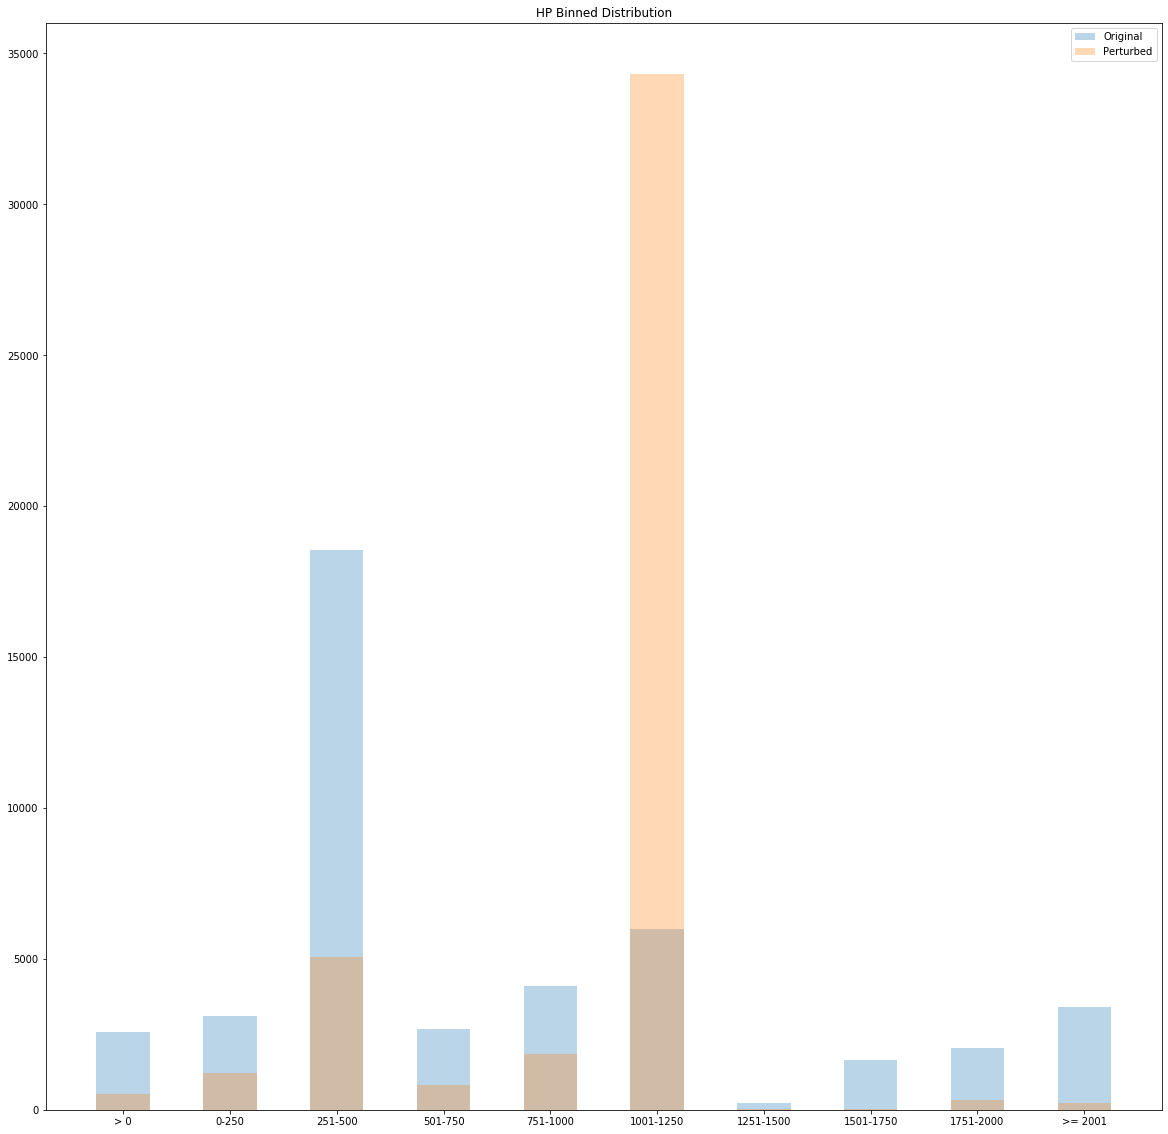

In [704]:
total = []
preturb = []
for i, hp in enumerate(tmodel(data).reshape(-1)): 
    total.append(binHP(hp))

for i, p in enumerate(tmodel(data_preturb).reshape(-1)):
    preturb.append(binHP(p))

plt.figure(figsize=(20,20))
plt.hist(total, rwidth=0.5, align='left', alpha=0.3, label='Original')
plt.hist(preturb, rwidth=0.5, align='left', alpha=0.3, label='Perturbed')
plt.legend(loc='upper right')

plt.xticks(np.arange(10), ('> 0','0-250','251-500','501-750','751-1000','1001-1250','1251-1500','1501-1750','1751-2000','>= 2001'))
plt.title('HP Binned Distribution')
plt.show()